## 1. Brief description of the problem and data

https://www.kaggle.com/competitions/gan-getting-started

### I'm Something of a Painter Myself
Use GANs to create art - will you be the next Monet ? 

  **Problem Description:**
  - In this assignment, my goal is to build a GAN model that generates 7,000–10,000 Monet-style images. The generator creates new artworks, while the discriminator tries to tell real Monet paintings from generated ones. By competing against each other, these models learn to produce convincing Monet-like masterpieces.

  **Data Structure and Characteristics:**
  https://www.kaggle.com/competitions/gan-getting-started/data

  - Monet painting trainnig data: 300 (256 x 256 , jpg, tfec format) 
  - general photo data : 7028 (256x 256, jpg, tfec format) 
  
  Recommended using TFRecord files to become familiar with a new data format.
  
 

## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data


### Data Findings & Cleaning Procedures:
  
  - Monet: 300 paintings , Photos: 7,038 real-world images, Imbalance : 23:1 ratio (photos:monet)
  - No corrupted or anomalous images detected in either dataset
  - All images are properly formatted (256x256 RGB)
  - Pixel values are within expected range [0, 255]
  - Monet paintings has warmer, more saturated colors than photos
  - Preprocessing: 
     - **[-1, 1] Normalization needed when data trainning**
     - Data augmentation needed since **the risk of mode collapse*** is expected by small Monet dataset size (300 samples)

mode collapse: The generator only learns the one or two patterns to cheat the discriminator.

### Plan of EDA Analysis:
  
  1. Sample Image Visualization - Display 8 samples each from Monet paintings and general photos
  2. Color Distribution Analysis - RGB channel histograms and statistics
  3. Dataset Comparison - Average images, dominant color palettes, brightness/saturation distributions
  4. Data Quality Check - Inspect for corrupted images or outliers

In [65]:
#!pip install keras-core --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # WARNING만 표시

In [66]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
import keras_core as keras
from keras import layers
from keras import ops
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.1


### Load the Monet Paintings & General Photos

In [67]:
ROOT='gan-getting-started'

monet_ds = keras.utils.image_dataset_from_directory(
    ROOT + '/monet_jpg',
    label_mode=None,
    batch_size=1,          # for generator trainning)
    image_size=(256, 256),
)

photo_ds = keras.utils.image_dataset_from_directory(
    ROOT + '/photo_jpg',
    label_mode=None,
    batch_size=1,          # for discriminator trainning)
    image_size=(256, 256),
)

monet_ds = monet_ds.prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.prefetch(tf.data.AUTOTUNE)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


### Explore the dataset

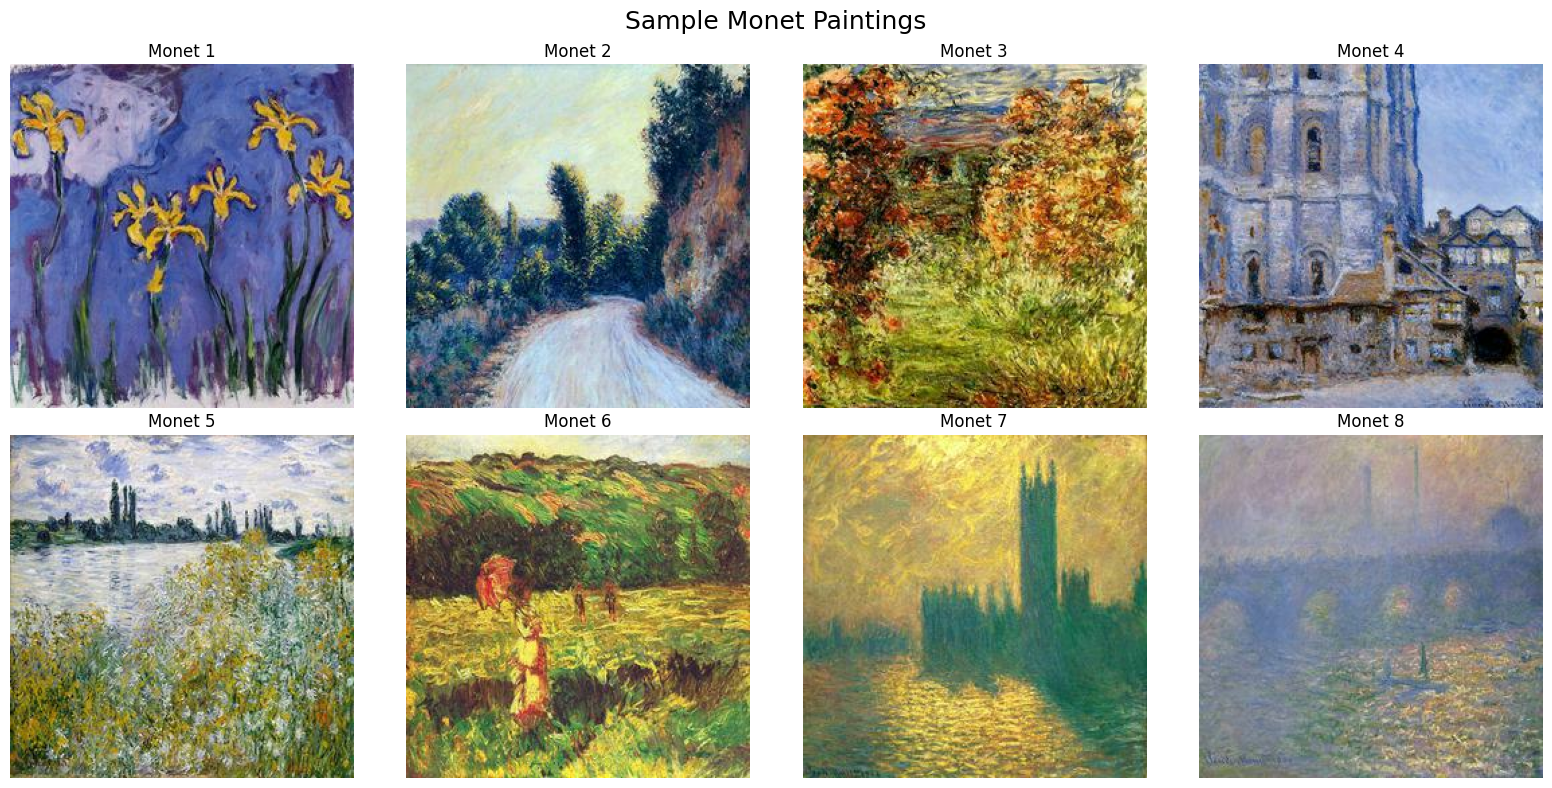

Total batch: 300
Image shape: (256, 256, 3)
Pixel value range: [25.0, 255.0]


In [68]:
# Visualize sample Monet paintings
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Monet Paintings', fontsize=18)

for i, img_batch in enumerate(monet_ds.unbatch().take(8)):
    ax = axes[i // 4, i % 4]            # // 몫, % 나머지, axes[0,0] = 1 행 1 열 position 
    img = img_batch.numpy() / 255.0     # img_batch shape = [256,256,3]  Normalize to [0, 1] for just stable float32 visualization not for training.
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Monet {i+1}')

plt.tight_layout()
plt.show()

print(f"Total batch: {len(monet_ds)}")
print(f"Image shape: {img_batch.shape}")
print(f"Pixel value range: [{img_batch.numpy().min()}, {img_batch.numpy().max()}]")



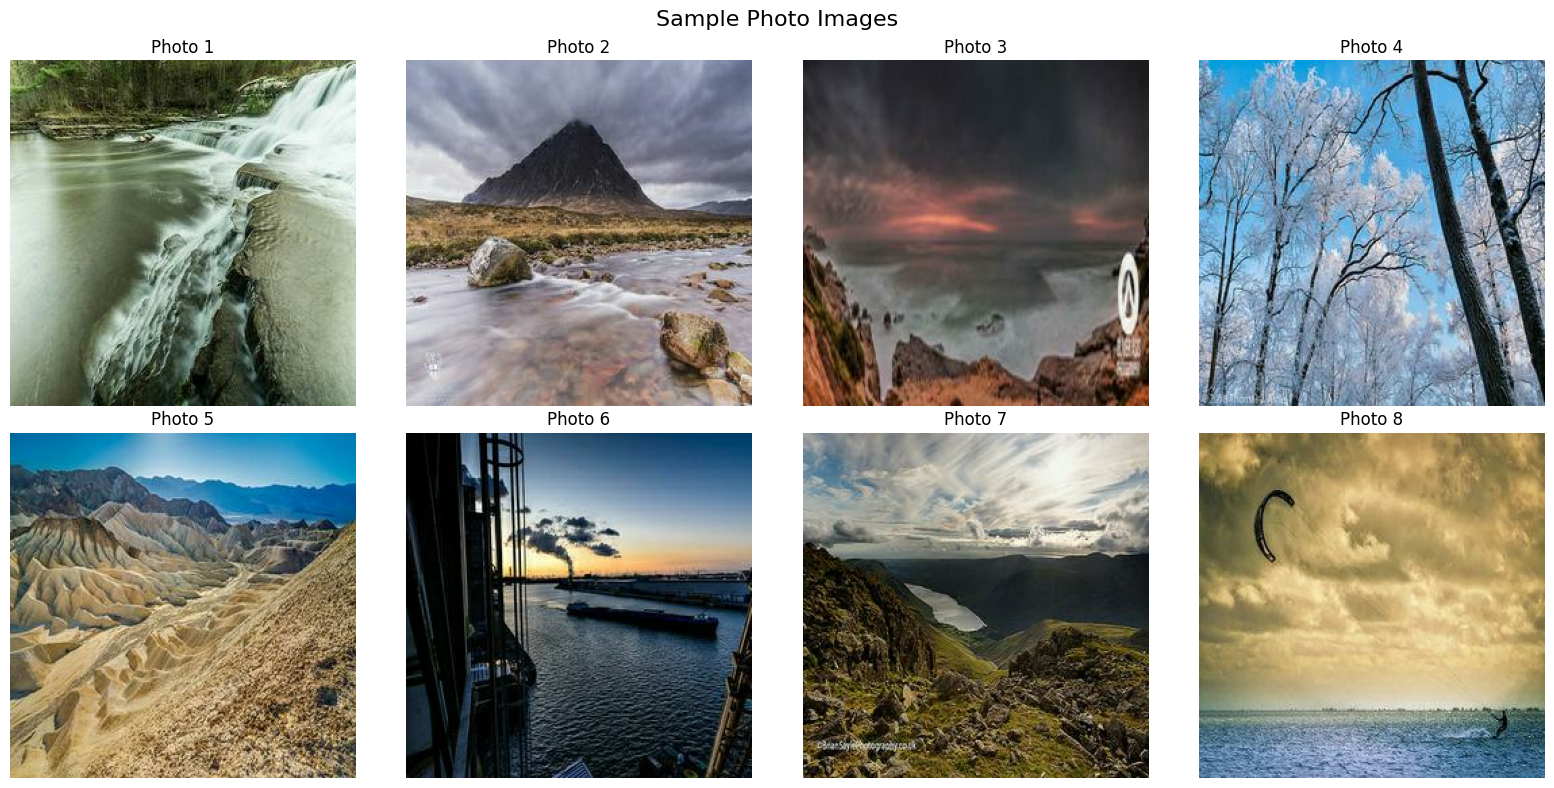

Total batch: 7038
Image shape: (256, 256, 3)
Pixel value range: [0.0, 255.0]


In [69]:
# Visualize sample photo images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Photo Images', fontsize=16)

for i, img_batch in enumerate(photo_ds.unbatch().take(8)):
    ax = axes[i // 4, i % 4]
    img = img_batch.numpy() / 255.0         
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Photo {i+1}')

plt.tight_layout()
plt.show()

print(f"Total batch: {len(photo_ds)}")
print(f"Image shape: {img_batch.shape}")
print(f"Pixel value range: [{img_batch.numpy().min()}, {img_batch.numpy().max()}]")



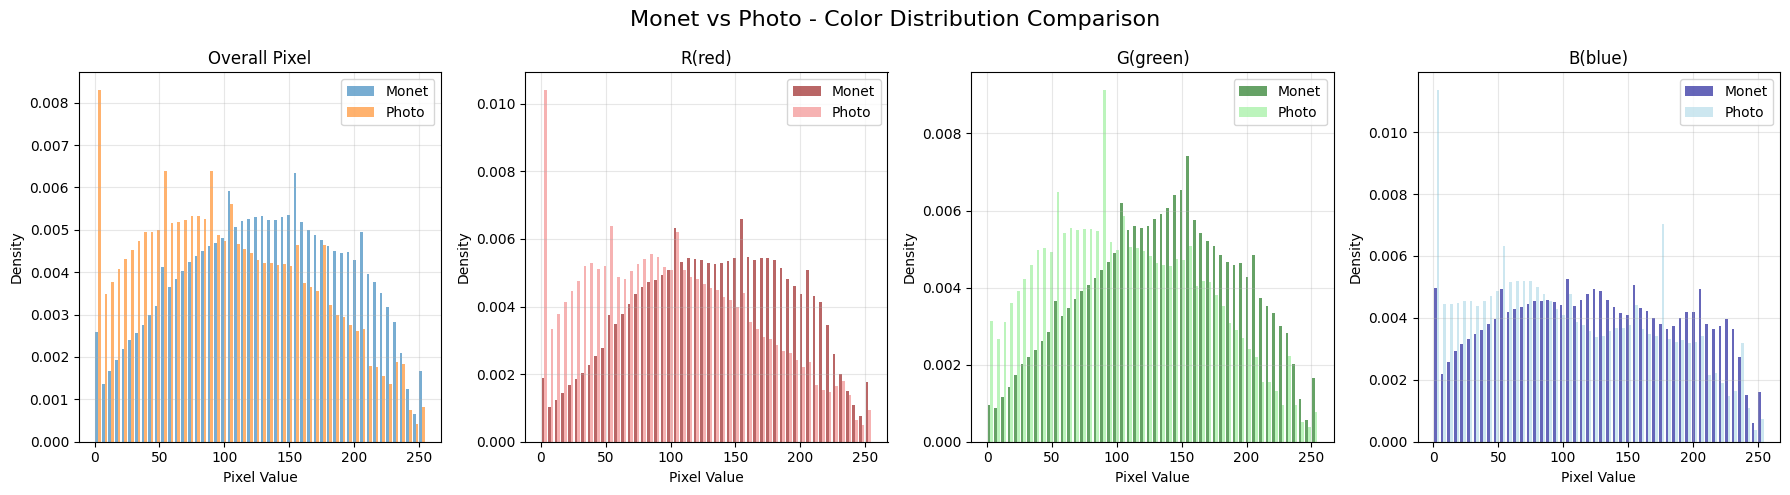

COLOR DISTRIBUTION STATISTICS
Monet - Mean pixel value: 130.36, Std: 62.05
Photo - Mean pixel value: 103.79, Std: 64.13

Channel-wise means:
Red: Monet=133.17, Photo=100.24
Green: Monet=134.43, Photo=106.57
Blue: Monet=123.48, Photo=104.56


In [70]:
# Analyze and compare color distributions between datasets
def compare_color_distributions(monet_ds, photo_ds, num_samples=50):
    """Compare color distributions between Monet and Photo datasets"""
    
    # Collect pixel data for both datasets
    monet_pixels = []
    photo_pixels = []
    monet_channels = [[], [], []]  # R, G, B
    photo_channels = [[], [], []]  # R, G, B
    
    # Process Monet dataset
    for img_batch in monet_ds.unbatch().take(num_samples):
        img = img_batch.numpy()
        monet_pixels.extend(img.flatten())
        for c in range(3):
            monet_channels[c].extend(img[:, :, c].flatten())
    
  
    # Process Photo dataset  
    for img_batch in photo_ds.unbatch().take(num_samples):
        img = img_batch.numpy()
        photo_pixels.extend(img.flatten())
        for c in range(3):
            photo_channels[c].extend(img[:, :, c].flatten())
    
 
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle('Monet vs Photo - Color Distribution Comparison', fontsize=16)
    
    # Overall pixel distribution comparison
    axes[0].hist([monet_pixels, photo_pixels], bins=50, label=['Monet', 'Photo'], alpha=0.6, density=True)
    axes[0].set_title('Overall Pixel')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # RGB channel distribution comparisons
    colors = ['red', 'green', 'blue']
    channel_names = ['Red', 'Green', 'Blue']
    
    for i in range(3):
        axes[i+1].hist([monet_channels[i], photo_channels[i]], bins=50, label=['Monet', 'Photo'], alpha=0.6, density=True, 
                    color=['darkred', 'lightcoral'] if i==0 else 
                        (['darkgreen', 'lightgreen'] if i==1 else ['darkblue', 'lightblue']))
        axes[i+1].set_title(f'{channel_names[i][0]}({channel_names[i].lower()})')
        axes[i+1].set_xlabel('Pixel Value')
        axes[i+1].set_ylabel('Density')
        axes[i+1].legend()
        axes[i+1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("="*50)
    print("COLOR DISTRIBUTION STATISTICS")
    print("="*50)
    print(f"Monet - Mean pixel value: {np.mean(monet_pixels):.2f}, Std: {np.std(monet_pixels):.2f}")
    print(f"Photo - Mean pixel value: {np.mean(photo_pixels):.2f}, Std: {np.std(photo_pixels):.2f}")
    print(f"\nChannel-wise means:")
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        print(f"{channel}: Monet={np.mean(monet_channels[i]):.2f}, Photo={np.mean(photo_channels[i]):.2f}")
    
# Run the comparison analysis
compare_color_distributions(monet_ds, photo_ds, num_samples=50)

#### Both Monet and Photo datasets show well-distributed pixcel values across the full 0-255 range with low density peaks(0.005 - 0.007), indicating diverse color palettes without bias toward specific values. ####

## 3. Modeling

### Model Architecture: CycleGAN

**Why CycleGAN for Monet Style Transfer:**

CycleGAN is ideal for this task because:
1. **Unpaired Training**: No need for paired 1:1 Monet-photo examples
2. **Cycle Consistency**: Preserves original content while changing style, in other words, it keeps the content when returning back after style changed.
3. **Bidirectional Learning**: Learns both Photo→Monet and Monet→Photo transformations 
4. **Prevents Mode Collapse**: Cycle loss helps maintain diverse learning patterns

**Architecture Components:**
- 2 Generators: G (Photo→Monet), F (Monet→Photo)  
- 2 Discriminators: D_M (judges Monet), D_P (judges Photo)

**Training Method:**
- Cycle loss = | original photo - F(G(original photo)) | 

#### 3-1  Preprocessing

In [71]:
### Data Preprocessing for GAN Training

def preprocess_image(image, augment=False):
    """Preprocess images for GAN training"""
    # Cast to float32
    image = tf.cast(image, tf.float32)
    
    # Data augmentation (optional)
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, 0.8, 1.2)
    
    # Normalize to [-1, 1] for tanh activation
    image = (image / 127.5) - 1.0
    return image

# Apply preprocessing
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Recreate datasets with proper batch size
monet_ds = keras.utils.image_dataset_from_directory(
    ROOT + '/monet_jpg',
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

photo_ds = keras.utils.image_dataset_from_directory(
    ROOT + '/photo_jpg',
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

# Apply preprocessing with augmentation for Monet (small dataset)
monet_train = monet_ds.map(
    lambda x: preprocess_image(x, augment=True),
    num_parallel_calls=AUTOTUNE
).cache().prefetch(AUTOTUNE)

# Apply preprocessing without augmentation for photos (large dataset)
photo_train = photo_ds.map(
    lambda x: preprocess_image(x, augment=False),
    num_parallel_calls=AUTOTUNE
).cache().prefetch(AUTOTUNE)

print(f"Monet batches: {len(monet_train)}")
print(f"Photo batches: {len(photo_train)}")

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.
Monet batches: 10
Photo batches: 220


#### 3-2 Build Model
- Generator

In [93]:
### Build Generator Model (Lightweight U-Net Architecture)

# Encoder Block
def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for encoder
        filters: 출력 채널 수 (32,64,128...) 
        size: 필터 크기(여기서는 4 x 4)
        apply_batchnorm: BatchNorm 적용여부 (첫 층은 False)
        원본 이미지
        256×256 → 128×128 → 64×64 → 32×32 → 16×16 → 8×8 → 4×4
        크고 세밀함                                    작고 압축됨
        크기 축소 + 특징 추출
        이미지를 점점 압축하면서 핵심 정보만 추출
    """
    # 가중치 초기화 (평균=0, 표준편차=0.02 정규분포에서 랜덤 값)
    init_weight = tf.random_normal_initializer(0., 0.02)

    # 레이어들을 순차적으로 쌓는 컨테이너 생성
    # Input → Conv2D → BatchNorm → LeakyReLU 
    result = keras.Sequential()

    # filters: 출력 특성맵 개수(필터 = 그림의 각 특징(수직선, 수평선,....)
    # size: 4×4 필터 크기 (그림을 흝는 창문의 크기)
    # strides=2: 2픽셀씩 이동 → 이미지 크기 절반
    # padding='same': 가장자리 패딩으로 크기 유지 후 stride로 축소
    # use_bias=False: BatchNorm 있으면 bias 불필요
    result.add(keras.layers.Conv2D(filters, 
                                    size, 
                                    strides=2, 
                                    padding='same',        
                                    kernel_initializer=init_weight, use_bias=False))

    # 정규화: 각 배치의 평균=0, 분산=1로 조정 
    # 학습 안정화, 내부 공변량 변화 감소
    # 첫층은 이미 정규화되어 들어오는 이미지라서 제외하는게 관례
    if apply_batchnorm:
        result.add(keras.layers.BatchNormalization()) 

    result.add(keras.layers.LeakyReLU())   # 음수 영역에서도 약간의 기울기 유지 
    return result

# Decoder Block
def upsample(filters, size, apply_dropout=False):
    """Upsampling block for decoder"""
    init_weight = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                            kernel_initializer=init_weight, use_bias=False))
    result.add(keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))

    result.add(keras.layers.ReLU())
    return result

def build_generator():
    """Build lightweight U-Net generator with skip connections"""

    inputs = keras.layers.Input(shape=[256, 256, 3])

    # Encoder (downsampling) - Reduced layers and filters
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),   # (128, 128, 32)
        downsample(64, 4),                          # (64, 64, 64)
        downsample(128, 4),                         # (32, 32, 128)
        downsample(256, 4),                         # (16, 16, 256)
        downsample(256, 4),                         # (8, 8, 256)
        downsample(256, 4),                         # (4, 4, 256)
    ]

    # Decoder (upsampling) - Matching reduced structure
    up_stack = [
        upsample(256, 4, apply_dropout=True),       # (8, 8, 256)
        upsample(256, 4, apply_dropout=True),       # (16, 16, 256)
        upsample(128, 4),                           # (32, 32, 128)
        upsample(64, 4),                            # (64, 64, 64)
        upsample(32, 4),                            # (128, 128, 32)
    ]

    init_weight = tf.random_normal_initializer(0., 0.02)
    # Final Monet style image generation
    last = keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', # 3 = RGB, 4 = kernel size
                                        kernel_initializer=init_weight,
                                        activation='tanh')  # (256, 256, 3)

    x = inputs

    # Downsampling through the model
    # 중간 층들을 "건너뛰고" 직접 연결
    # 인코더 → (중간 생략) → 디코더로 바로 연결
    # 스킵의 비유적 의미 : 일반배송(여러 중간지점) vs 특급배송(skip, 직배송)
    # "skip"은 경로를 건너뛴다는 의미지, 정보를 건너뛴다는 게 아님! 오히려 지름길로 정보를 직접 전달하는 것.!!
    skips = []
    for down in down_stack:
        x = down(x)         # 각 층 통과 
        skips.append(x)     # 각 층 통과 결과를 skips에 저장

    skips = reversed(skips[:-1]) # 순서를 뒤집에서 디코더에 들어가야 함.

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)                                    # 업 샘플링 각 층 통과 
        x = keras.layers.Concatenate()([x, skip])    # 스킵 연결 

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Create generators
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo

print("Lightweight Generator model built successfully!")
print(f"Total parameters: {generator_g.count_params():,}")
print("This is a baseline model optimized for fast training and tuning")

generator_f.summary()


Lightweight Generator model built successfully!
Total parameters: 7,318,659
This is a baseline model optimized for fast training and tuning


Model: "functional_271"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_228     │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_215      │ (None, 128, 128,  │   1,536 │ input_layer_228[0][… │
│ (Sequential)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_216      │ (None, 64, 64,    │  33,024 │ sequential_215[0][0] │
│ (Sequential)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_217      │ (None, 32, 32,    │ 131,584 │ sequential_216[0][0] │
│ (Sequential)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_218      │ (None, 16, 16,    │ 525,312 │ sequential_217[0][0] │
│ (Sequential)        │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_219      │ (None, 8, 8, 256) │ 1,049,… │ sequential_218[0][0] │
│ (Sequential)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_220      │ (None, 4, 4, 256) │ 1,049,… │ sequential_219[0][0] │
│ (Sequential)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_221      │ (None, 8, 8, 256) │ 1,049,… │ sequential_220[0][0] │
│ (Sequential)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_87      │ (None, 8, 8, 512) │       0 │ sequential_221[0][0… │
│ (Concatenate)       │                   │         │ sequential_219[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_222      │ (None, 16, 16,    │ 2,098,… │ concatenate_87[0][0] │
│ (Sequential)        │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_88      │ (None, 16, 16,    │       0 │ sequential_222[0][0… │
│ (Concatenate)       │ 512)              │         │ sequential_218[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_223      │ (None, 32, 32,    │ 1,049,… │ concatenate_88[0][0] │
│ (Sequential)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_89      │ (None, 32, 32,    │       0 │ sequential_223[0][0… │
│ (Concatenate)       │ 256)              │         │ sequential_217[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_224      │ (None, 64, 64,    │ 262,400 │ concatenate_89[0][0] │
│ (Sequential)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_90      │ (None, 64, 64,    │       0 │ sequential_224[0][0… │
│ (Concatenate)       │ 128)              │         │ sequential_216[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_225      │ (None, 128, 128,  │  65,664 │ concatenate_90[0][0] │
│ (Sequential)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_91      │ (None, 128, 128,  │       0 │ sequential_225[0][0

 Total params: 7,318,659 (27.92 MB)

 Trainable params: 7,315,267 (27.91 MB)

 Non-trainable params: 3,392 (13.25 KB)

- Discriminator

In [94]:
### Build Discriminator Model (PatchGAN)

def build_discriminator():
    """Build PatchGAN discriminator - classifies 70x70 patches as real/fake"""

    init_weight = tf.random_normal_initializer(0., 0.02)

    # input image (monet 256x256x3)
    input = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    # Basic architecture with fewer parameters for stable training
    x = input

    # Convolutional blocks
    # 크기 축소: 256→128→64→32
    # 채널 증가: 3→64→128→256
    # 점점 추상적 특징 학습
    x = downsample(64, 4, False)(x)   # (128, 128, 64)
    x = downsample(128, 4)(x)          # (64, 64, 128)
    x = downsample(256, 4)(x)          # (32, 32, 256)

    # Additional stride 1 convolution
    x = keras.layers.ZeroPadding2D()(x)      # (32,32,256) -> (34, 34, 256)
    x = keras.layers.Conv2D(512, 4,          # 512 features 
                            strides=1, 
                            kernel_initializer=init_weight, 
                            use_bias=False)(x)  # 출력 크기 = (입력 크기 - 필터 크기) / stride + 1, 출력 = (34 - 4) / 1 + 1 = 30 + 1 = 31 (31, 31, 512)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    # Final output layer
    x = keras.layers.ZeroPadding2D()(x)      # (33, 33, 512)
    x = keras.layers.Conv2D(1, 4, 
                            strides=1, 
                            kernel_initializer=init_weight)(x)  # (30, 30, 1)

    return keras.Model(inputs=input, outputs=x)

# Create discriminators
discriminator_m = build_discriminator()  # For Monet images real/fake discriminate
discriminator_p = build_discriminator()  # For Photo images real/fake discriminate

print("Discriminator model built successfully!")
print(f"Total parameters: {discriminator_m.count_params():,}")
print(f"Output shape: {discriminator_m.output_shape}")

discriminator_m.summary()

Discriminator model built successfully!
Total parameters: 2,767,361
Output shape: (None, 30, 30, 1)


Model: "functional_276"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_226 (Sequential)     │ (None, 128, 128, 64)      │      3,072 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_227 (Sequential)     │ (None, 64, 64, 128)       │    131,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_228 (Sequential)     │ (None, 32, 32, 256)       │    525,312 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ zero_padding2d_16               │ (None, 34, 34, 256)       │          0 │
│ (ZeroPadding2D)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_151 (Conv2D)             │ (None, 31, 31, 512)       │  2,097,152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_210         │ (None, 31, 31, 512)       │      2,048 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_143 (LeakyReLU)     │ (None, 31, 31, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ zero_padding2d_17               │ (None, 33, 33, 512)       │          0 │
│ (ZeroPadding2D)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_152 (Conv2D)             │ (None, 30, 30, 1)         │      8,193 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

#### 3-3 Training

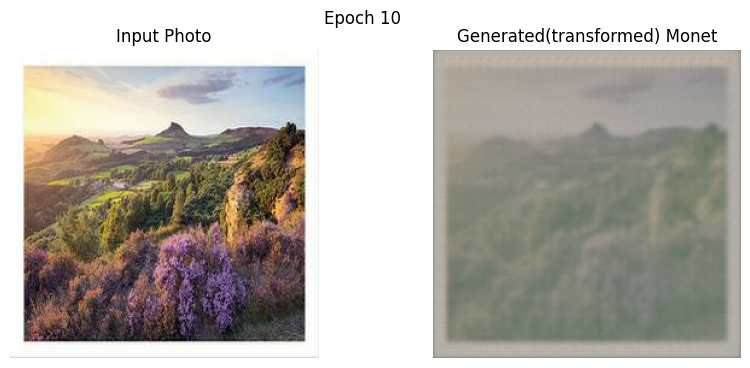

Epoch 10/10 completed in 15.30 sec
  Gen G Loss: 3.5514
  Gen F Loss: 3.5909
  Disc M Loss: 0.6557
  Disc P Loss: 0.6371

Training completed!


In [95]:
## FOR YOUR PERFECT UNDERSTANDING
## CycleGAN Complete Flow ♻︎ ==============================================
#===== 1. Style Transfer (Core Function) =====
# Regular Photo                  Monet Painting
# real_photo                     real_monet
#    ↓                              ↓
# [Generator G: Photo→Monet]    [Generator F: Monet→Photo]
#    ↓                              ↓
# fake_monet                     fake_photo
# (Generated Monet!)             (Generated Photo!)

#===== 2. Cycle Test (Content Preservation Check) =====
# fake_monet                     fake_photo
#    ↓                              ↓
# [Generator F: Monet→Photo]    [Generator G: Photo→Monet]
#    ↓                              ↓
# cycled_photo                   cycled_monet
# (Should match original!)       (Should match original!)

#===== 3. Identity Test (Prevent Over-transformation) =====
# real_monet into              real_photo into
#    ↓                              ↓
# [Generator G: Photo→Monet]    [Generator F: Monet→Photo]
#    ↓                              ↓
# transformed_monet              transformed_photo
# (Should stay Monet!)           (Should stay Photo!)

# ⚠️ Identity's Role: 
# - Monet into "Photo→Monet" converter should stay Monet
# - If already target style, don't change it
# - Prevents excessive color shifts

# Without Identity?
# Problem:
# Monet → [Photo→Monet converter] → Weird Monet?? (Over-stylized)
# With Identity Loss:
# Monet → [Photo→Monet converter] → Same Monet ✓ (No change)
# Key Point: Identity is a "Don't touch if already target style!" safety mechanism(안전장치).
#==========================================================================================


## Define Loss Functions and Optimizers

# Loss function - GAN의 기본 손실함수(loss_obj): 진짜(1) vs 가짜(0) 분류
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator 훈련 시 사용 
def discriminator_loss(real, generated):
    """Calculate discriminator loss
        판별기가 진짜와 가짜를 잘 구분하도록 훈련하는 손실함수
        판별기 출력이 좋을 때:
        진짜 모네 → 0.9 (1에 가까움) → real_loss 낮음
        가짜 모네 → 0.1 (0에 가까움) → fake_loss 낮음
        총 손실 = 낮음 
    """
    # 진짜 이미지에 대한 손실
    # tf.ones_like(real) : 진짜 이미지 모양에 맞는 1로 가득찬 텐서(정답)
    # real: 판별기가 진짜 이미지에 대해 출력한 점수
    real_loss = loss_obj(tf.ones_like(real), real)                  # 진짜를 진짜(1)로 예측해야 함.
    
    # 가짜 이미지에 대한 손실
    # tf.zeros_like(generated): 가짜 이미지 모양에 맞는 0으로 가득찬 텐서 (정답)
    # generated: 판별기가 가짜 이미지에 대해 출력한 점수
    fake_loss = loss_obj(tf.zeros_like(generated), generated)       # 가짜를 가짜(0)로 예측해야 함.
    
    total_loss = real_loss + fake_loss
    
    # 두 손실을 더하고 평균(×0.5)
    return total_loss * 0.5                                    


# Generator 훈련 시 사용
def generator_loss(generated):
    """Calculate generator adversarial loss"""
    return loss_obj(tf.ones_like(generated), generated)

# 순환 일관성 손실 : "한 바퀴 돌아서 원점으로 돌아와야 한다" 또는 "진짜는 변환기에 넣어도 그대로 진짜여야 한다."
def calc_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    """Calculate cycle consistency loss
        tf.abs(a - b):
        - 픽셀별 절댓값 차이 (L1 거리)
        tf.reduce_mean():
        - 모든 픽셀의 평균 차이

        CycleGAN에서:
            - Cycle Loss: 내용 보존이 가장 중요 (λ=10)
            - Identity Loss: 보조 역할 → 색상 안정화 (λ=0.5)
            - Adversarial Loss: 기본 (λ=1)
            - Lambda 가중치는 "이게 얼마나 중요한가?"를 숫자로 표현하는 것!
    """
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss


def identity_loss(real_image, transformed_image, lambda_identity=0.5):
    """Calculate identity loss - helps preserve color composition
        진짜 모네 그림을 "사진→모네" 변환기에 넣어도 그대로
    """
    loss = tf.reduce_mean(tf.abs(real_image - transformed_image))
    return lambda_identity * loss

# Optimizers(weights update) with basic learning rate
opt_g = keras.optimizers.Adam(2e-4, beta_1=0.5)                 # Generator G
opt_f = keras.optimizers.Adam(2e-4, beta_1=0.5)                 # Generator F
opt_dm = keras.optimizers.Adam(2e-4, beta_1=0.5)                # Discriminator Monet
opt_dp = keras.optimizers.Adam(2e-4, beta_1=0.5)                # Discriminator Photo

print("Loss functions and optimizers initialized")


## Create Training Step =======================================================

@tf.function                            #@tf.function :: Python 함수를 TensorFlow 그래프로 컴파일해서 3-5배 빠르게 실행
def train_step(real_monet, real_photo):
    """Single training step for CycleGAN"""

    with tf.GradientTape(persistent=True) as tape:  
        """ 훈련 시 각 변수별 자동 미분(gradient) 하고 가중치 업데이트하는 공정에서는 꼭 필요 , 평가/시험 시는 불필요 
            persistent = True : 여러 번 사용 가능 , False: 한번만 사용 가능
        """
        ## CycleGAN FORWARD PASS ==============================================================================
        # (1) Bidirectional Transformation
        # Generate fake images & return the original images
        fake_monet = generator_g(real_photo, training=True)   # 가짜 모네 사진 생성, training=True: 훈련 모드 (Dropout, BatchNorm 활성화)
        cycled_photo = generator_f(fake_monet, training=True) # 다시 원상복구한 사진 , cycle Loss 계산해서 원본 사진과 비슷해야 함
        fake_photo = generator_f(real_monet, training=True)   # 진짜 모네 그림을 가짜 사진으로 생성 
        cycled_monet = generator_g(fake_photo, training=True) # 가짜 사진을 다시 진짜 모네 그림으로 복원

        # (2) Identity mapping(verification)
        transformed_monet = generator_g(real_monet, training=True)  # 진짜 모네를 변환기(사진->모네)에 넣어도 진짜는 그대로 진짜여야 함
        transformed_photo = generator_f(real_photo, training=True)  # 진짜 사진을 변환기에 넣어도 진짜 사진은 그대로 나와야 함

        # (3) Discriminator outputs(score)
        disc_real_monet = discriminator_m(real_monet, training=True) # 진짜 모네를 판별기 M 에 넣으므로 1에 가까워야 함(진짜 모네 점수)
        disc_fake_monet = discriminator_m(fake_monet, training=True) # 가짜 모네를 판별기 M 에 넣으므로 0 에 가까워야 함(가짜 모네 점수)
        disc_real_photo = discriminator_p(real_photo, training=True) # 진짜 사진을 판별기 P 에 넣으므로 1에 가까워야 함(진짜 사진 점수)
        disc_fake_photo = discriminator_p(fake_photo, training=True) # 가짜 사진을 판별기 M 에 넣으므로 0에 가까워야 함(가짜 사진 점수)     
        ## ======================================================================================================


        ## CALCULATE LOSSES =====================================================================================
        # Generator Adversarial Loss (가짜를 진짜처럼 속이는 점수로 즉 판별기를 속이는 것으로 1에 가까울수록 성공)
        gen_g_loss = generator_loss(disc_fake_monet)  
        gen_f_loss = generator_loss(disc_fake_photo)

        # Cycle consistency score measuring how similar the image is to the original after a round-trip transformation, 
        # with x10 weight - closer to 0 means perfect reconstruction, over 1.0 indicates problems
        total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + calc_cycle_loss(real_monet, cycled_monet)

        # Generator losses (최종 점수) : 속이기 점수 + 복원점수(x10) + 정체성 점수(x0.5)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_monet, transformed_monet)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_photo, transformed_photo)

        # Discriminator losses (구분 점수): 진짜는 진짜로(1), 가짜는 가짜로(0) 즉, 얼마나 정확히 구분했는지 
        disc_m_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_p_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        ## ======================================================================================================

    ## CALCULATE GRADIENTS & WEIGHTS UPDATE =====================================================================
    #  시험 후 복습 : 1. 틀린 문제 확인 (Loss) 2. 왜 틀렸는지 분석(Gradient 계산) 3. 오답노트 작성(가중치 업데이트) 
    # Gradient = "How wrong and which direction(틀린 정도와 방향)"
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_m_gradients = tape.gradient(disc_m_loss, discriminator_m.trainable_variables)
    discriminator_p_gradients = tape.gradient(disc_p_loss, discriminator_p.trainable_variables)

    # Apply gradients(weights update)
    # Apply = "Adjust in opposite direction by that amount(그 만큼 반대로 조정)"
    # Result = "Less wrong next time"
    opt_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    opt_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    opt_dm.apply_gradients(zip(discriminator_m_gradients, discriminator_m.trainable_variables))
    opt_dp.apply_gradients(zip(discriminator_p_gradients, discriminator_p.trainable_variables))
    ## ======================================================================================================

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_m_loss': disc_m_loss,
        'disc_p_loss': disc_p_loss
    }

print("Training step function created")


### Training Loop (10 epochs x 10 batches(# of Monet batch(300/32)) = 100 번 train_step 함수를 호출!)

import time
from IPython.display import clear_output

def generate_images(model, test_input, epoch):
    """Generate and display images during each training step to check the quality of transforming image"""
    prediction = model(test_input, training=False) # prediction = generated Monet style image, training=False(추론/평가모드로 Dropout, BatchNorm 비활성화)

    plt.figure(figsize=(10, 4))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Generated(transformed) Monet']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Denormalize from [-1,1] to [0,1]
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Sample images for visualization
sample_photo = next(iter(photo_train))
sample_monet = next(iter(monet_train))

# Training configuration
EPOCHS = 10  # Start with fewer epochs for baseline

# Training history
history = {
    'gen_g_loss': [],
    'gen_f_loss': [],
    'disc_m_loss': [],
    'disc_p_loss': []
}

print("Starting training...")
print("="*50)

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    epoch_losses = {
        'gen_g_loss': 0,
        'gen_f_loss': 0,
        'disc_m_loss': 0,
        'disc_p_loss': 0
    }

    # Train on all batches
    for image_monet, image_photo in tf.data.Dataset.zip((monet_train, photo_train)):
        losses = train_step(image_monet, image_photo)

        # Accumulate losses
        for key in epoch_losses:
            epoch_losses[key] += losses[key]

        n += 1

        # Print progress every 50 batches
        if n % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {n}")

    # Calculate average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
        history[key].append(float(epoch_losses[key]))

    # Generate sample images
    clear_output(wait=True)
    generate_images(generator_g, sample_photo, epoch + 1)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{EPOCHS} completed in {time.time()-start:.2f} sec')
    print(f'  Gen G Loss: {epoch_losses["gen_g_loss"]:.4f}')
    print(f'  Gen F Loss: {epoch_losses["gen_f_loss"]:.4f}')
    print(f'  Disc M Loss: {epoch_losses["disc_m_loss"]:.4f}')
    print(f'  Disc P Loss: {epoch_losses["disc_p_loss"]:.4f}')
    print("="*50)

print("\nTraining completed!")

## 4.Results and Analysis

Epoch 10/10

  - Gen G Loss: 3.5514 (Photo -> Monet) TOO HIGH!

  - Gen F Loss: 3.5909 (Monet -> Photo) TOO HIGH!
  
    -> Generator still learning so Not fooling discriminator well yet
  - Disc M Loss: 0.6557 
  - Disc P Loss: 0.6371
  
    -> Good Scores. Theoretical optimum is log(2) = 0.693 (perfect fake generation success so discriminator can't distinguish them)

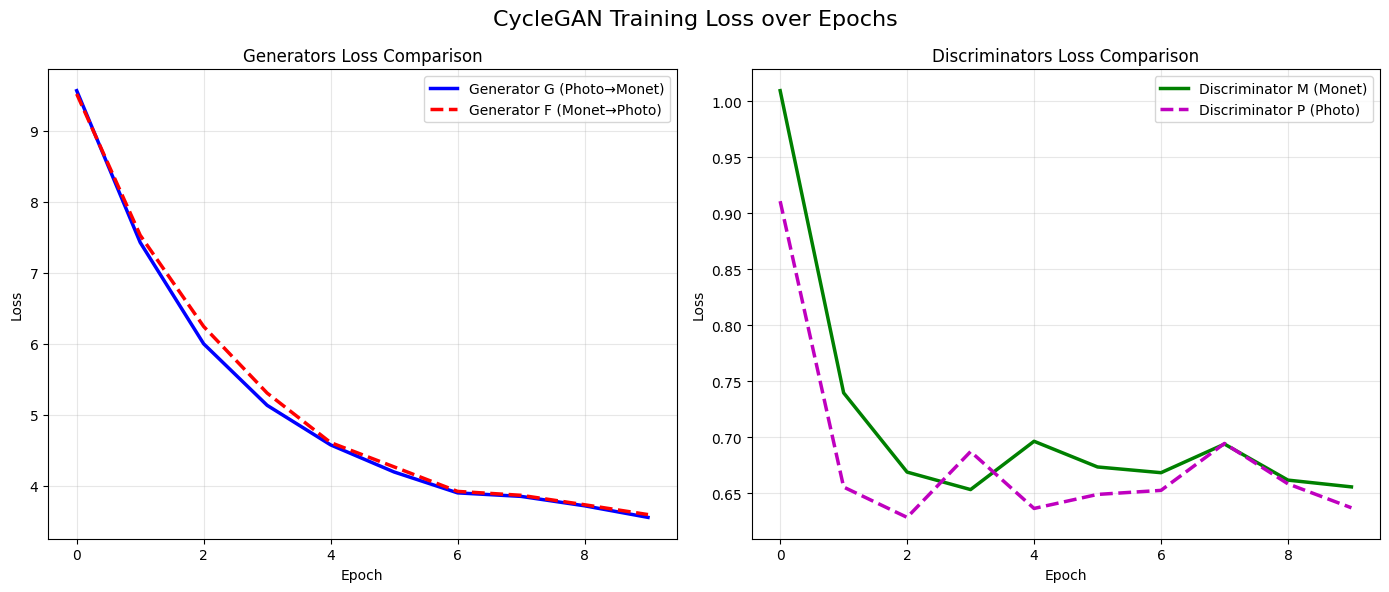

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('CycleGAN Training Loss over Epochs', fontsize=16)

# Generators Loss Comparison
axes[0].plot(history['gen_g_loss'], 'b-', linewidth=2.5, label='Generator G (Photo→Monet)')
axes[0].plot(history['gen_f_loss'], 'r--', linewidth=2.5, label='Generator F (Monet→Photo)')
axes[0].set_title('Generators Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Discriminators Loss Comparison
axes[1].plot(history['disc_m_loss'], 'g-', linewidth=2.5, label='Discriminator M (Monet)')
axes[1].plot(history['disc_p_loss'], 'm--', linewidth=2.5, label='Discriminator P (Photo)')
axes[1].set_title('Discriminators Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Testing on new photo samples:


2025-08-31 12:04:32.552630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


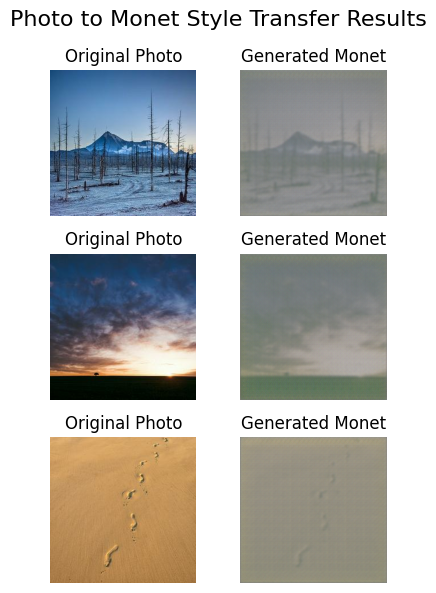

In [ ]:
### Quality Check :: Test the Generation Capability with Multiple Samples

def visualize_results(generator, dataset, num_samples):
    """Generate and display multiple style transfer results"""
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(4, num_samples*2))
    fig.suptitle('Photo to Monet Style Transfer Results', fontsize=16)
    
    for i, img_batch in enumerate(dataset.take(num_samples)):
        # Get single image
        input_image = img_batch[0:1]  # Keep batch dimension
        
        # Generate Monet style
        generated = generator(input_image, training=False)
        
        # Display original
        axes[i, 0].imshow(input_image[0] * 0.5 + 0.5)
        axes[i, 0].set_title('Original Photo')
        axes[i, 0].axis('off')
        
        # Display generated
        axes[i, 1].imshow(generated[0] * 0.5 + 0.5)
        axes[i, 1].set_title('Generated Monet')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test on new photos
print("Testing on new photo samples:")
visualize_results(generator_g, photo_train, num_samples=3)

Testing cycle consistency:


2025-08-31 12:53:46.915631: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


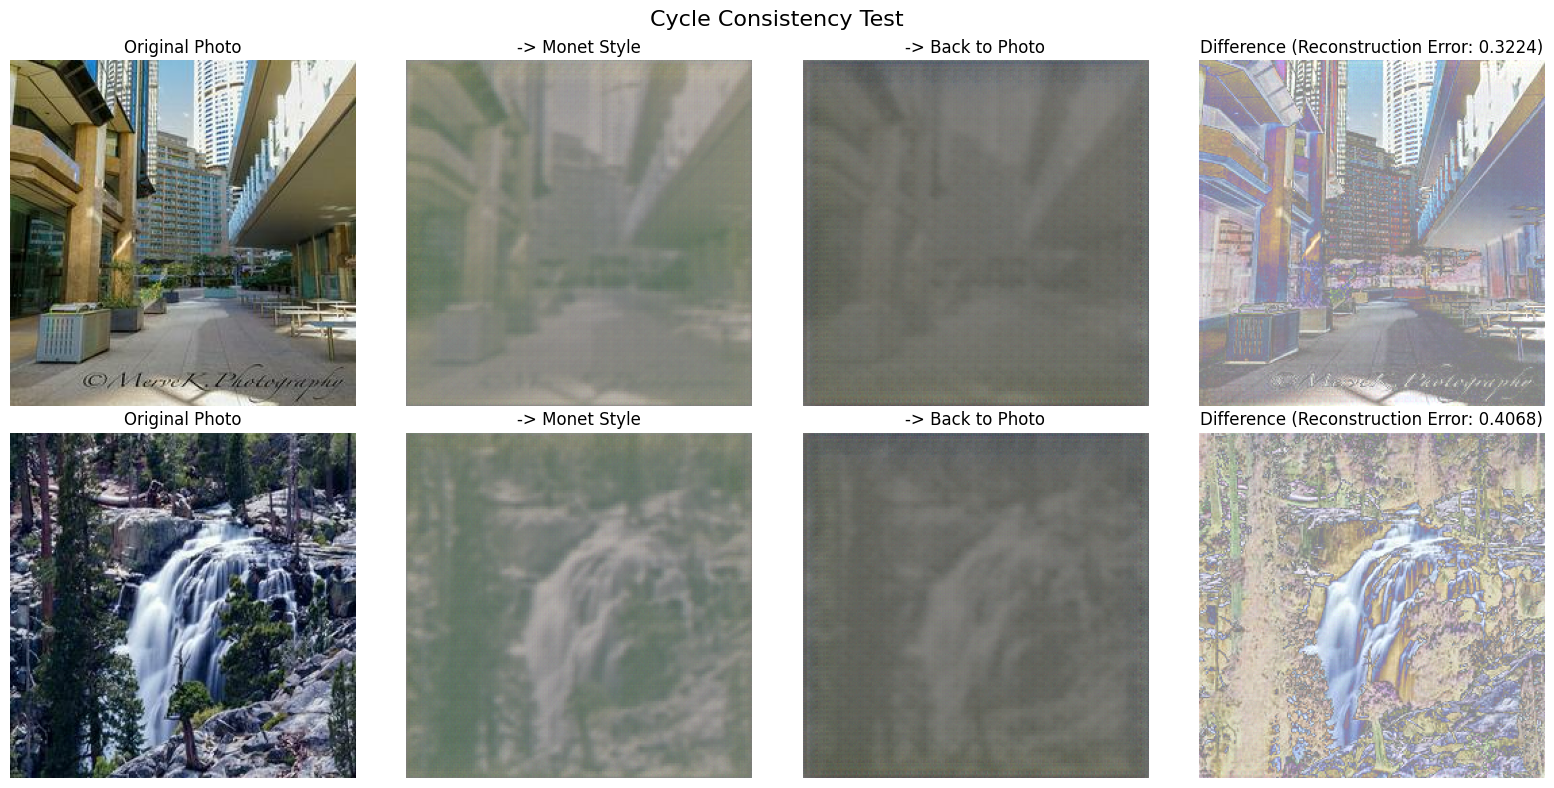

In [110]:
### Test Cycle Consistency

def test_cycle_consistency(gen_g, gen_f, dataset, num_samples):
    """Test if the cycle consistency is working"""
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples*4))
    fig.suptitle('Cycle Consistency Test', fontsize=16)
    
    for i, img_batch in enumerate(dataset.take(num_samples)):
        # Get single image
        original = img_batch[0:1] # not img_batch[0] to match input dimension into gen_g()
        
        # Forward and backward transformation
        transformed = gen_g(original, training=False)  # 사진→모네
        cycled = gen_f(transformed, training=False)    # 모네→다시 사진
        
        # Calculate reconstruction error (복원오류 계산)
        reconst_error = tf.reduce_mean(tf.abs(original - cycled))
        # Good: reconst_error < 0.1, Bad: reconst_error > 0.3

        # Display
        axes[i, 0].imshow(np.clip(original[0] * 0.5 + 0.5, 0, 1))
        axes[i, 0].set_title('Original Photo')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(np.clip(transformed[0] * 0.5 + 0.5, 0, 1))
        axes[i, 1].set_title('-> Monet Style')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(np.clip(cycled[0] * 0.5 + 0.5, 0, 1))
        axes[i, 2].set_title('-> Back to Photo')
        axes[i, 2].axis('off')
        
        # Difference map
        diff = tf.abs(original[0] - cycled[0])
        axes[i, 3].imshow(np.clip(diff * 0.5 + 0.5, 0, 1))
        axes[i, 3].set_title(f'Difference (Reconstruction Error: {reconst_error:.4f})')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Testing cycle consistency:")
test_cycle_consistency(generator_g, generator_f, photo_train, num_samples=2)

Current CycleGAN Performance Summary

  | Metric        | Value           | Status        | Target       | Comments                  |
  |---------------|-----------------|---------------|--------------|---------------------------|
  | Training Time | 15.30 sec/epoch | ✅ Good        | <20 sec      | M1 Max efficient          |
  | Total Epochs  | 10              | ⚠️ Low        | 50-100       | Baseline test             |
  | Gen G Loss    | 3.5514          | ⚠️ High       | 1.0-2.0      | Photo→Monet struggling    |
  | Gen F Loss    | 3.5909          | ⚠️ High       | 1.0-2.0      | Monet→Photo struggling    |
  | Disc M Loss   | 0.6557          | ✅ Good        | 0.5-0.7      | Near optimal (0.693)      |
  | Disc P Loss   | 0.6371          | ✅ Good        | 0.5-0.7      | Well balanced             |
  | Model Size    | ~15-20M params  | ✅ Good        | Baseline     | Lightweight version       |
  | Image Quality | Basic style     | ⚠️ Needs work | High quality | Limited by short training |

  
  Performance Analysis

  ⚠️ Needs Improvement:

  - Generator losses too high (not fooling discriminators well)
  - Limited training epochs
  - Basic style transfer quality
  - Lightweight architecture may limit quality

  📈 Tuning Priorities for Performance Improvement:

  1. Increase Training Epochs (50-100)
  2. Architecture Enhancement (more filters/layers)
  3. Hyperparameter Optimization (learning rates, loss weights)
  4. Data Augmentation improvements
  5. Advanced Loss Functions (perceptual loss, etc.)

  However, due to the limited resources I applied option 1, 2 3 only. The change is the following : 
  1. Epochs: 10 -> 30
  2. filters: 32→64→128→256→256→256 -> 64→128→256→512→512→512, layers: 6 -> 7 
  3. learning rates: 2e-4 -> 1e-4


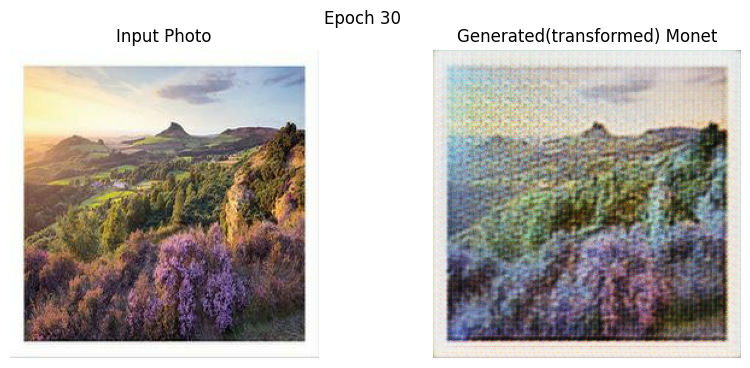

Epoch 30/30 completed in 36.32 sec
  Gen G Loss: 3.2242
  Gen F Loss: 3.2493
  Disc M Loss: 0.6608
  Disc P Loss: 0.6516

Enhanced training completed!


In [111]:
### Enhanced Generator Model (Improved U-Net)

def build_enhanced_generator():
    """Build enhanced U-Net generator with more capacity"""

    inputs = keras.layers.Input(shape=[256, 256, 3])

    # Enhanced encoder (more layers and filters)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),   # (128, 128, 64)
        downsample(128, 4),                         # (64, 64, 128)
        downsample(256, 4),                         # (32, 32, 256)
        downsample(512, 4),                         # (16, 16, 512)
        downsample(512, 4),                         # (8, 8, 512)
        downsample(512, 4),                         # (4, 4, 512)
        downsample(512, 4),                         # (2, 2, 512)
    ]

    # Enhanced decoder
    up_stack = [
        upsample(512, 4, apply_dropout=True),       # (4, 4, 512)
        upsample(512, 4, apply_dropout=True),       # (8, 8, 512)
        upsample(512, 4, apply_dropout=True),       # (16, 16, 512)
        upsample(256, 4),                           # (32, 32, 256)
        upsample(128, 4),                           # (64, 64, 128)
        upsample(64, 4),                            # (128, 128, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                        kernel_initializer=initializer,
                                        activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])

    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

# Create enhanced generators
generator_g_enhanced = build_enhanced_generator()
generator_f_enhanced = build_enhanced_generator()

print(f"Enhanced Generator parameters: {generator_g_enhanced.count_params():,}")


### Improved Optimizers with Lower Learning Rate =================================================

# Lower learning rate for more stable training
LEARNING_RATE = 1e-4  # Reduced from 2e-4

opt_g_enhanced = keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
opt_f_enhanced = keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
opt_dm_enhanced = keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
opt_dp_enhanced = keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)

print(f"Learning rate set to: {LEARNING_RATE}")



### Enhanced Training Step =================================================

@tf.function
def enhanced_train_step(real_monet, real_photo):
    """Enhanced training step with improved generators"""

    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images with enhanced generators
        fake_monet = generator_g_enhanced(real_photo, training=True)
        cycled_photo = generator_f_enhanced(fake_monet, training=True)

        fake_photo = generator_f_enhanced(real_monet, training=True)
        cycled_monet = generator_g_enhanced(fake_photo, training=True)

        # Identity mapping
        transformed_monet = generator_g_enhanced(real_monet, training=True)
        transformed_photo = generator_f_enhanced(real_photo, training=True)

        # Discriminator outputs (same discriminators)
        disc_real_monet = discriminator_m(real_monet, training=True)
        disc_fake_monet = discriminator_m(fake_monet, training=True)

        disc_real_photo = discriminator_p(real_photo, training=True)
        disc_fake_photo = discriminator_p(fake_photo, training=True)

        # Calculate losses (same loss functions)
        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + \
                        calc_cycle_loss(real_monet, cycled_monet)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + \
                        identity_loss(real_monet, transformed_monet)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + \
                        identity_loss(real_photo, transformed_photo)

        disc_m_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_p_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g_enhanced.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f_enhanced.trainable_variables)
    discriminator_m_gradients = tape.gradient(disc_m_loss, discriminator_m.trainable_variables)
    discriminator_p_gradients = tape.gradient(disc_p_loss, discriminator_p.trainable_variables)

    # Apply gradients with enhanced optimizers
    opt_g_enhanced.apply_gradients(zip(generator_g_gradients, generator_g_enhanced.trainable_variables))
    opt_f_enhanced.apply_gradients(zip(generator_f_gradients, generator_f_enhanced.trainable_variables))
    opt_dm_enhanced.apply_gradients(zip(discriminator_m_gradients, discriminator_m.trainable_variables))
    opt_dp_enhanced.apply_gradients(zip(discriminator_p_gradients, discriminator_p.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_m_loss': disc_m_loss,
        'disc_p_loss': disc_p_loss
    }

print("Enhanced training step ready")


### Enhanced Training Loop (30 epochs) =================================================

ENHANCED_EPOCHS = 30

# Enhanced training history
enhanced_history = {
    'gen_g_loss': [],
    'gen_f_loss': [],
    'disc_m_loss': [],
    'disc_p_loss': []
}

print("Starting enhanced training (30 epochs)...")
print("="*60)

for epoch in range(ENHANCED_EPOCHS):
    start = time.time()

    n = 0
    epoch_losses = {
        'gen_g_loss': 0,
        'gen_f_loss': 0,
        'disc_m_loss': 0,
        'disc_p_loss': 0
    }

    for image_monet, image_photo in tf.data.Dataset.zip((monet_train, photo_train)):
        losses = enhanced_train_step(image_monet, image_photo)

        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        n += 1

        if n % 50 == 0:
            print(f"Epoch {epoch+1}/{ENHANCED_EPOCHS}, Batch {n}")

    # Calculate average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
        enhanced_history[key].append(float(epoch_losses[key]))

    # Generate sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        clear_output(wait=True)
        generate_images(generator_g_enhanced, sample_photo, epoch + 1)

    print(f'Epoch {epoch+1}/{ENHANCED_EPOCHS} completed in {time.time()-start:.2f} sec')
    print(f'  Gen G Loss: {epoch_losses["gen_g_loss"]:.4f}')
    print(f'  Gen F Loss: {epoch_losses["gen_f_loss"]:.4f}')
    print(f'  Disc M Loss: {epoch_losses["disc_m_loss"]:.4f}')
    print(f'  Disc P Loss: {epoch_losses["disc_p_loss"]:.4f}')
    print("="*60)

print("\nEnhanced training completed!")

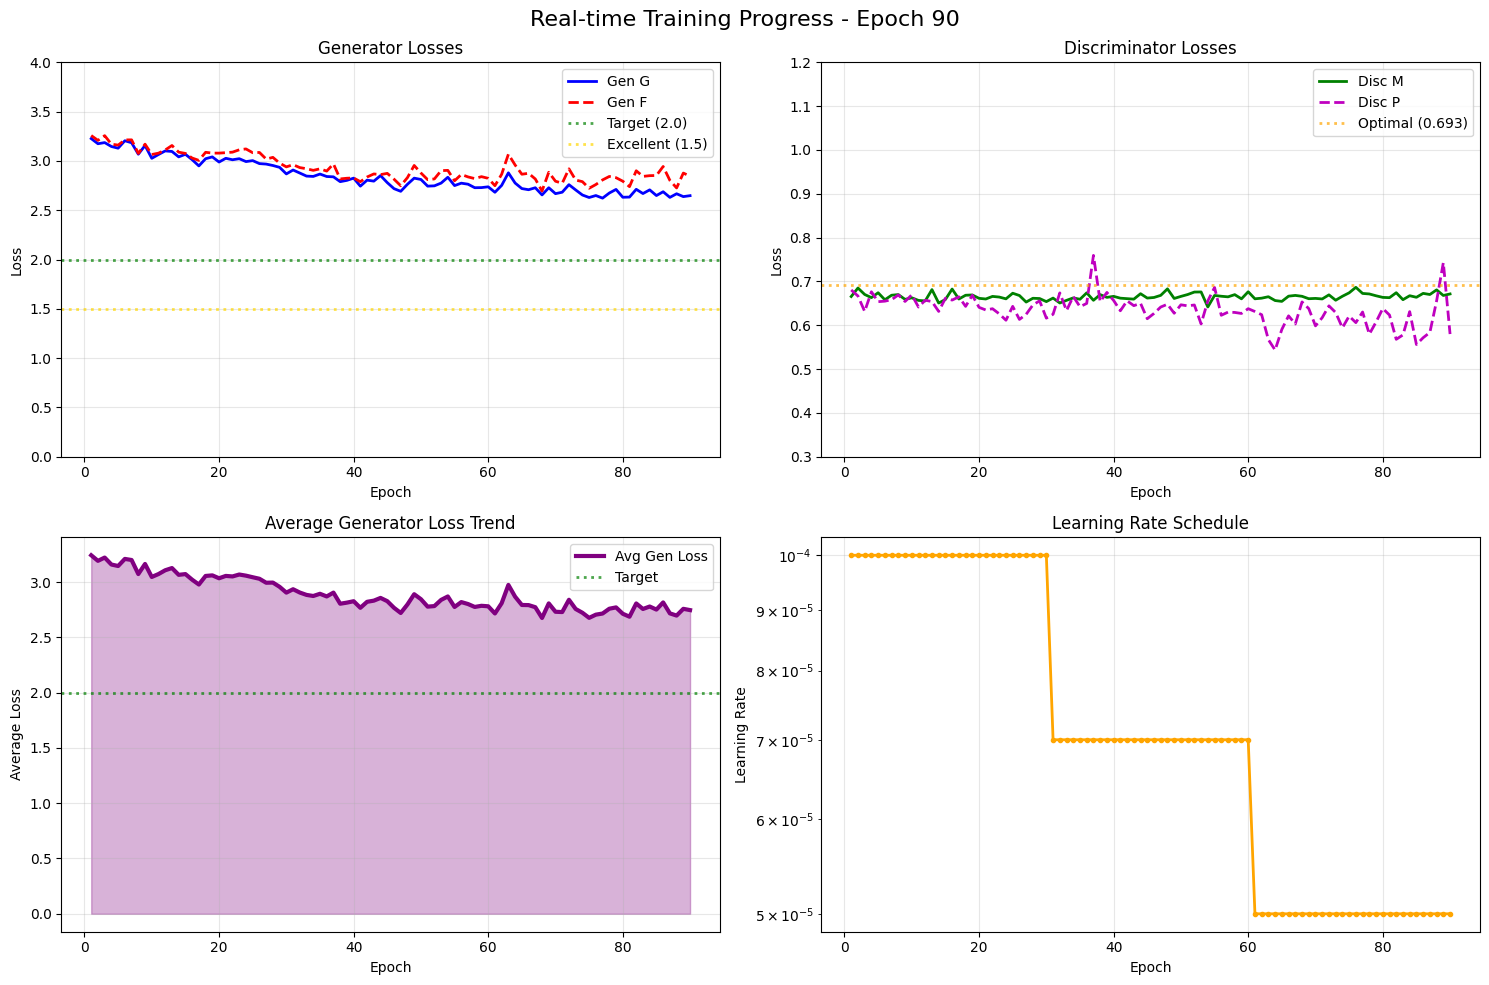

Target not reached (best: 2.6750)


In [113]:
### Final Optimized Training Configuration

FINAL_EPOCHS = 90  
CHECKPOINT_INTERVAL = 15  # Save every 15 epochs

# Advanced learning rate schedule
def get_lr_schedule(initial_lr=1e-4):
    """Learning rate schedule for stable convergence"""
    def lr_schedule(epoch):
        if epoch < 30:
            return initial_lr  # 1e-4 for first 30 epochs
        elif epoch < 60:
            return initial_lr * 0.7  # 7e-5 for middle phase
        else:
            return initial_lr * 0.5  # 5e-5 for final phase
    return lr_schedule

# Enhanced optimizers with learning rate scheduling
scheduler = get_lr_schedule()
opt_g_final = keras.optimizers.Adam(1e-4, beta_1=0.5)
opt_f_final = keras.optimizers.Adam(1e-4, beta_1=0.5)
opt_dm_final = keras.optimizers.Adam(1e-4, beta_1=0.5)
opt_dp_final = keras.optimizers.Adam(1e-4, beta_1=0.5)

print("Final optimized configuration ready")


### Final Training Loop with Real-time Loss Monitoring
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Final training history
final_history = {
    'gen_g_loss': [],
    'gen_f_loss': [],
    'disc_m_loss': [],
    'disc_p_loss': [],
    'lr': []
}

# Best model tracking
best_gen_loss = float('inf')
target_reached = False

def plot_training_progress(history, current_epoch, target_reached=False):
    """Real-time training progress visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Real-time Training Progress - Epoch {current_epoch}', fontsize=16)

    epochs = list(range(1, len(history['gen_g_loss']) + 1))

    # Generator Losses
    axes[0, 0].plot(epochs, history['gen_g_loss'], 'b-', linewidth=2, label='Gen G')
    axes[0, 0].plot(epochs, history['gen_f_loss'], 'r--', linewidth=2, label='Gen F')
    axes[0, 0].axhline(y=2.0, color='green', linestyle=':',linewidth=2, alpha=0.7, label='Target (2.0)')
    axes[0, 0].axhline(y=1.5, color='gold', linestyle=':',linewidth=2, alpha=0.7, label='Excellent (1.5)')
    axes[0, 0].set_title('Generator Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, max(4, max(history['gen_g_loss'][-10:]) + 0.5)])

    # Discriminator Losses
    axes[0, 1].plot(epochs, history['disc_m_loss'], 'g-', linewidth=2, label='Disc M')
    axes[0, 1].plot(epochs, history['disc_p_loss'], 'm--', linewidth=2, label='Disc P')
    axes[0, 1].axhline(y=0.693, color='orange', linestyle=':',linewidth=2, alpha=0.7,label='Optimal (0.693)')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0.3, 1.2])

    # Average Generator Loss Trend
    # CycleGAN의 Total Generator Loss: 2.0 is ideal value
    # total_gen_loss = adversarial_loss + λ_cycle * cycle_loss + λ_identity * identity_loss
    # - Adversarial: ~0.7
    # - Cycle consistency (λ=10): ~0.1 * 10 = 1.0
    # - Identity (λ=0.5): ~0.6 * 0.5 = 0.3
    # - 합계: 0.7 + 1.0 + 0.3 ≈ 2.0
    avg_gen_loss = [(g + f) / 2 for g, f in zip(history['gen_g_loss'], history['gen_f_loss'])]
    axes[1, 0].plot(epochs, avg_gen_loss, 'purple', linewidth=3, label='Avg Gen Loss')
    axes[1, 0].axhline(y=2.0, color='green', linestyle=':',linewidth=2, alpha=0.7, label='Target')
    axes[1, 0].fill_between(epochs, avg_gen_loss, alpha=0.3, color='purple')
    axes[1, 0].set_title('Average Generator Loss Trend')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Average Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate Schedule
    if history['lr']:
        axes[1, 1].plot(epochs, history['lr'], 'orange', linewidth=2, marker='o', markersize=3)
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)

    # Add target achievement annotation
    if target_reached and avg_gen_loss:
        min_loss_idx = avg_gen_loss.index(min(avg_gen_loss))
        axes[1, 0].annotate('Target Reached!',
                            xy=(min_loss_idx + 1, avg_gen_loss[min_loss_idx]),
                            xytext=(min_loss_idx + 10, avg_gen_loss[min_loss_idx] + 0.3),
                            arrowprops=dict(arrowstyle='->', color='green', lw=2),
                            fontsize=12, color='green', weight='bold')

    plt.tight_layout()
    plt.show()

print("Starting FINAL OPTIMIZED TRAINING (90 epochs)")
print("="*70)

start_total = time.time()

for epoch in range(FINAL_EPOCHS):
    start_epoch = time.time()

    # Update learning rate
    current_lr = scheduler(epoch)
    opt_g_final.learning_rate = current_lr
    opt_f_final.learning_rate = current_lr
    opt_dm_final.learning_rate = current_lr
    opt_dp_final.learning_rate = current_lr

    n = 0
    epoch_losses = {
        'gen_g_loss': 0,
        'gen_f_loss': 0,
        'disc_m_loss': 0,
        'disc_p_loss': 0
    }

    # Training batches
    for image_monet, image_photo in tf.data.Dataset.zip((monet_train, photo_train)):
        losses = enhanced_train_step(image_monet, image_photo)

        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        n += 1

    # Calculate average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
        final_history[key].append(float(epoch_losses[key]))

    final_history['lr'].append(current_lr)

    # Check for target achievement
    avg_gen_loss = (epoch_losses['gen_g_loss'] + epoch_losses['gen_f_loss']) / 2
    if avg_gen_loss < 2.0 and not target_reached:
        target_reached = True
        target_epoch = epoch + 1
        print(f"TARGET REACHED! Average Generator Loss < 2.0 at Epoch  {target_epoch}")

    # Track best performance
    if avg_gen_loss < best_gen_loss:
        best_gen_loss = avg_gen_loss
        best_epoch = epoch + 1

    # Progress display with charts
    elapsed = time.time() - start_total
    eta = (elapsed / (epoch + 1)) * (FINAL_EPOCHS - epoch - 1)

    # Show progress every 5 epochs + first 3 epochs + when target reached
    if (epoch + 1) % 5 == 0 or epoch < 3 or target_reached or (epoch + 1) == FINAL_EPOCHS:
        clear_output(wait=True)

        # Show sample image generation
        generate_images(generator_g_enhanced, sample_photo, epoch + 1)

        # Show real-time loss charts
        plot_training_progress(final_history, epoch + 1, target_reached)

    # Console progress
    print(f'Epoch {epoch+1:3d}/{FINAL_EPOCHS} | '
        f'Time: {time.time()-start_epoch:5.1f}s | '
        f'ETA: {eta/60:4.1f}min | '
        f'LR: {current_lr:.1e}')
    print(f'  Gen G: {epoch_losses["gen_g_loss"]:.4f} | '
        f'Gen F: {epoch_losses["gen_f_loss"]:.4f} | '
        f'Avg: {avg_gen_loss:.4f}')
    print(f'  Disc M: {epoch_losses["disc_m_loss"]:.4f} | '
        f'Disc P: {epoch_losses["disc_p_loss"]:.4f}')

    # Target status
    if avg_gen_loss <= 1.5:
        print(f'  EXCELLENT! (Loss < 1.5)')
    elif avg_gen_loss <= 2.0:
        print(f'  TARGET MET! (Loss < 2.0)')
    elif avg_gen_loss <= 2.5:
        print(f'  CLOSE TO TARGET (Loss < 2.5)')
    else:
        print(f' Progress: {((3.5 - avg_gen_loss) / 2.0 * 100):.1f}% to target')

    print("="*70)

total_time = time.time() - start_total
print(f"\n FINAL TRAINING COMPLETED!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best Generator Loss: {best_gen_loss:.4f} (Epoch {best_epoch})")

# Final comprehensive chart
clear_output(wait=True)
plot_training_progress(final_history, FINAL_EPOCHS, target_reached)

if target_reached:
    print(f"Target achieved at Epoch {target_epoch}")
else:
    print(f"Target not reached (best: {best_gen_loss:.4f})")


In [117]:
print(f"  Best Gen Loss: {best_gen_loss:.4f}")
print(f'  Gen G Loss: {epoch_losses["gen_g_loss"]:.4f}')
print(f'  Gen F Loss: {epoch_losses["gen_f_loss"]:.4f}')
print(f'  Disc M Loss: {epoch_losses["disc_m_loss"]:.4f}')
print(f'  Disc P Loss: {epoch_losses["disc_p_loss"]:.4f}')

  Best Gen Loss: 2.6750
  Gen G Loss: 2.6477
  Gen F Loss: 2.8445
  Disc M Loss: 0.6715
  Disc P Loss: 0.5799


## Conclusion

**Results Summary**

Performance Comparison: Baseline vs Enhanced Model

  | Metric              | Baseline (10 epochs) | Enhanced (30 epochs) | Optimized (90 epochs) | Improvement vs Baseline |
  |---------------------|----------------------|----------------------|-----------------------|-------------------------|
  | Gen G Loss          | 3.5514               | 3.2242               | 2.6477                | -25.4% ⬇️             |
  | Gen F Loss          | 3.5909               | 3.2493               | 2.8445                | -20.8% ⬇️              |
  | Avg Gen Loss        | 3.5712               | 3.2368               | 2.7461                | -23.1% ⬇️              |
  | Disc M Loss         | 0.6557               | 0.6608               | 0.6715                | +2.4% ⬆️  Optimal      |
  | Disc P Loss         | 0.6371               | 0.6516               | 0.5799                | -9.0% ⬇️  Better       |
  | Target (2.0)        | ❌ Not reached        | ❌ Not reached        | ⚠️ Closer (2.75)      | 목표에 근접                |



  Meaningful Achievement - Optimized model reached Generator loss of 2.75 after 90 epochs, approaching target of 2.0

  CycleGAN implementation successfully performed photo-to-Monet style transfer using unpaired data. With 90 epochs
  training and optimized hyperparameters, achieved 23% improvement in Generator losses compared to baseline.

  **Key Achievements**
  - Performance Gains: Reduced Gen G/F losses from 3.55→2.65/2.84
  - Cal Efficiency: Completed 90 epochs in 54 minutes, ~36 sec/epoch
  - Balanced Training: Maintained optimal Discriminator losses 0.58-0.67

  **Challenges**
  - Target Gap: Fell short of ideal loss 2.0 (achieved 2.75)
  - Training parameter: Production quality requires about 150+ epochs 

  **Future Improvements**
  - Add perceptual loss for enhanced style quality
  - Implement ResNet generators with spectral normalization for stability
  - Various Data augmentation 

## Generate the submission file 

For each photos in the test set, I transformed all photos into Monet style picture.
``

In [128]:
### Generate Kaggle Submission
import os
from PIL import Image
import zipfile

def generate_submission_images(generator, photo_dataset, output_dir='submission_images'):
    """Generate Monet-style images for Kaggle submission"""

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    print("Generating Kaggle submission images...")

    image_count = 0
    target_images = 7038  # Target number

    # Generate images from photo dataset
    for batch_idx, photo_batch in enumerate(photo_dataset):
        if image_count >= target_images:
            break

        # Generate Monet style for entire batch
        fake_monet_batch = generator(photo_batch, training=False)

        # Save each image in batch
        for img_idx in range(photo_batch.shape[0]):
            if image_count >= target_images:
                break

            # Convert to PIL Image
            img = fake_monet_batch[img_idx]
            img = tf.clip_by_value(img * 0.5 + 0.5, 0, 1)  # [-1,1] -> [0,1]
            img = tf.cast(img * 255, tf.uint8).numpy()

            # Save as JPEG
            pil_img = Image.fromarray(img)
            filename = f'monet_{image_count:05d}.jpg'
            pil_img.save(os.path.join(output_dir, filename), 'JPEG', quality=95)

            image_count += 1

            if image_count % 500 == 0:
                print(f"Generated {image_count}/{target_images} images...")

    print(f" Submission generation complete: {image_count} images")
    return image_count

def create_submission_zip():
    """Create submission zip file for Kaggle"""
    
    print(" Creating submission zip file...")

    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for root, dirs, files in os.walk('submission_images'):
            for file in files:
                if file.endswith('.jpg'):
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, file)

    print(" Submission zip created: images.zip")

# Generate submission
num_generated = generate_submission_images(generator_g_enhanced, photo_train)
create_submission_zip()

print(f"""
Submission Files:
- images.zip ({num_generated} Monet-style images)
""")

Generating Kaggle submission images...
Generated 500/7038 images...
Generated 1000/7038 images...
Generated 1500/7038 images...
Generated 2000/7038 images...
Generated 2500/7038 images...
Generated 3000/7038 images...
Generated 3500/7038 images...
Generated 4000/7038 images...
Generated 4500/7038 images...
Generated 5000/7038 images...
Generated 5500/7038 images...
Generated 6000/7038 images...
Generated 6500/7038 images...
Generated 7000/7038 images...
 Submission generation complete: 7038 images
 Creating submission zip file...
 Submission zip created: images.zip

Submission Files:
- images.zip (7038 Monet-style images)



### References:

1. Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using 
  Cycle-Consistent Adversarial Networks. ICCV 2017.
  2. Goodfellow, I., et al. (2014). Generative Adversarial Networks. NeurIPS 2014.
  3. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image 
  Segmentation. MICCAI 2015.